In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)

In [ ]:
df = pd.read_csv("ftn.csv")
print("Loaded:", df.shape)
display(df.head())

Loaded: (7000, 5)


,note_id,entity_id,category,text,timestamp
0,N400000,E101498,rsvp,Confirmed attendance for robotics workshop.,30-08-2025 02:51
1,N400001,E101738,helpdesk,Wi-Fi not working in hostel block.,18-09-2025 03:03
2,N400002,E101590,maintenance,CCTV near library needs check.,06-09-2025 19:47
3,N400003,E101144,feedback,Broken chair in seminar room.,19-09-2025 09:05
4,N400004,E102891,incident,Wi-Fi not working in hostel block.,11-09-2025 13:28


In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%d-%m-%Y %H:%M", errors='coerce')
print("Timestamps parsed, nulls:", df['timestamp'].isna().sum())
df = df.dropna(subset=['timestamp']).reset_index(drop=True)
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month_name()

Timestamps parsed, nulls: 0


In [ ]:
print(df.info())
print(df['category'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   note_id    7000 non-null   object        
 1   entity_id  7000 non-null   object        
 2   category   7000 non-null   object        
 3   text       7000 non-null   object        
 4   timestamp  7000 non-null   datetime64[ns]
 5   date       7000 non-null   object        
 6   hour       7000 non-null   int32         
 7   weekday    7000 non-null   object        
 8   month      7000 non-null   object        
dtypes: datetime64[ns](1), int32(1), object(7)
memory usage: 465.0+ KB
None
category
maintenance    1441
feedback       1436
rsvp           1402
helpdesk       1365
incident       1356
Name: count, dtype: int64


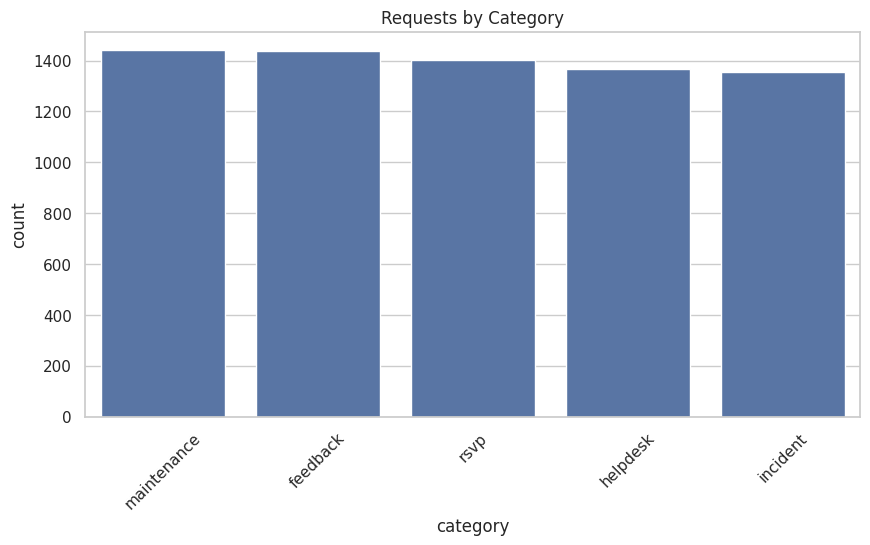

In [ ]:
plt.figure()
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.title("Requests by Category")
plt.xticks(rotation=45)
plt.show()

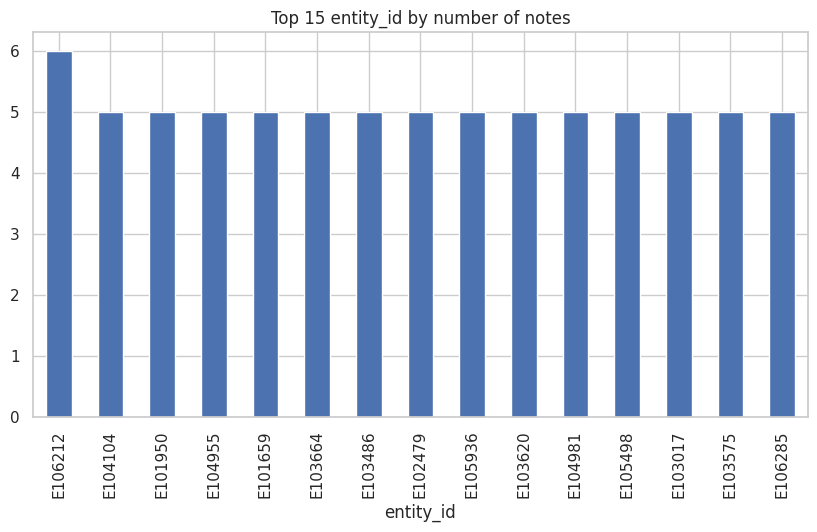

In [ ]:
plt.figure()
df['entity_id'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 entity_id by number of notes")
plt.show()

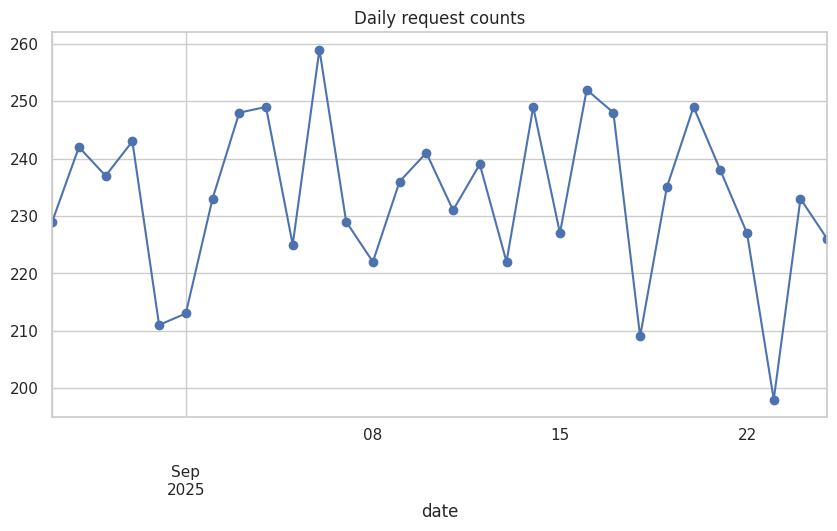

In [ ]:
daily_counts = df.groupby('date').size().rename("count").reset_index()
daily_counts['date'] = pd.to_datetime(daily_counts['date'])
daily_counts.set_index('date')['count'].plot(marker='o', title="Daily request counts")
plt.show()


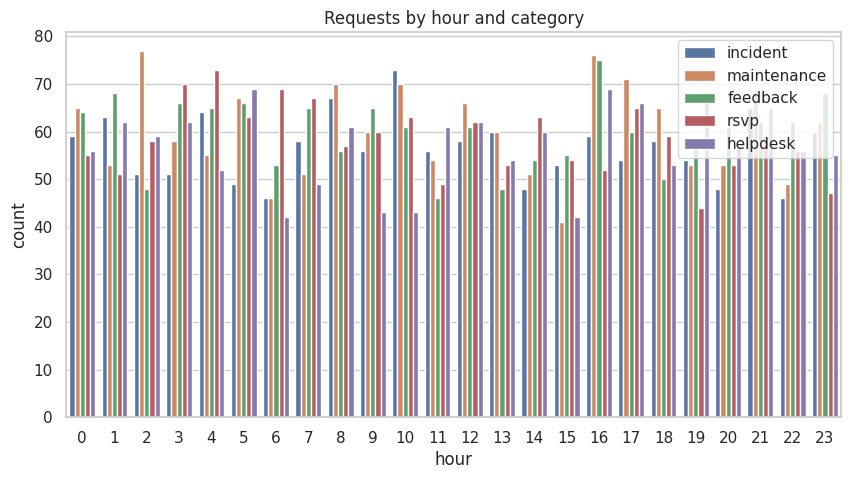

In [ ]:
plt.figure()
sns.countplot(data=df, x='hour', hue='category')
plt.title("Requests by hour and category")
plt.legend(loc='upper right')
plt.show()

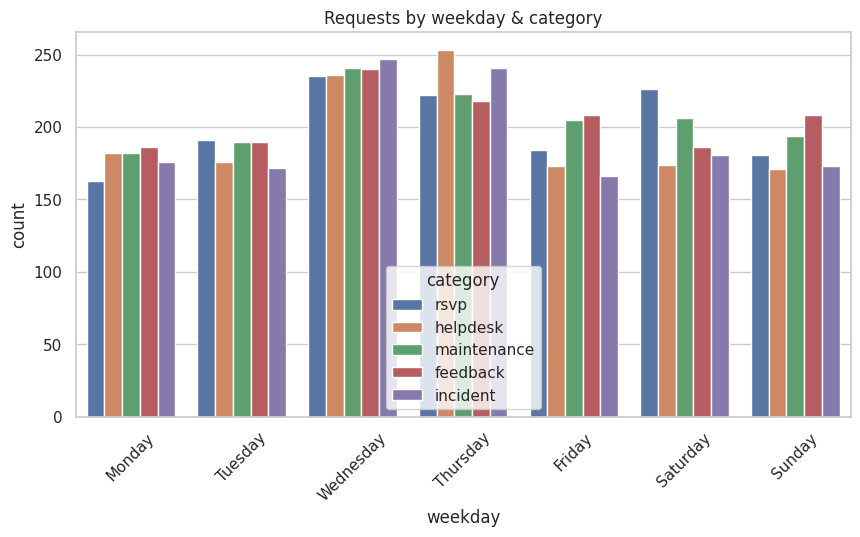

In [ ]:
plt.figure()
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(data=df, x='weekday', order=order, hue='category')
plt.title("Requests by weekday & category")
plt.xticks(rotation=45)
plt.show()


# Text preprocessing

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text_clean'] = df['text'].astype(str).apply(clean_text)

In [ ]:
print("Empty texts before:", (df['text_clean']=="").sum())

Empty texts before: 0


In [ ]:
def remove_stopwords(txt):
    tokens = txt.split()
    filtered = [t for t in tokens if t not in STOPWORDS and len(t)>1]
    return " ".join(filtered)

df['text_clean'] = df['text_clean'].apply(remove_stopwords)

print("Sample cleaned text:")
display(df[['text','text_clean']].head(7))

Sample cleaned text:


,text,text_clean
0,Confirmed attendance for robotics workshop.,confirmed attendance robotics workshop
1,Wi-Fi not working in hostel block.,wi fi working hostel block
2,CCTV near library needs check.,cctv near library needs check
3,Broken chair in seminar room.,broken chair seminar room
4,Wi-Fi not working in hostel block.,wi fi working hostel block
5,Requesting lab access.,requesting lab access
6,Wi-Fi not working in hostel block.,wi fi working hostel block


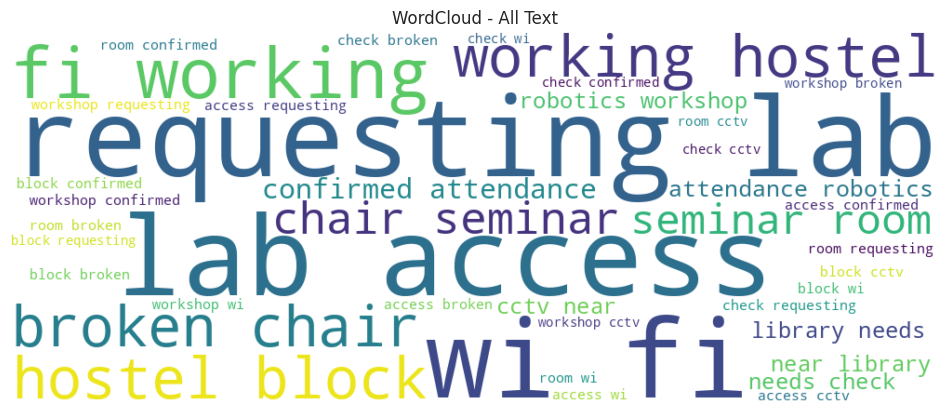

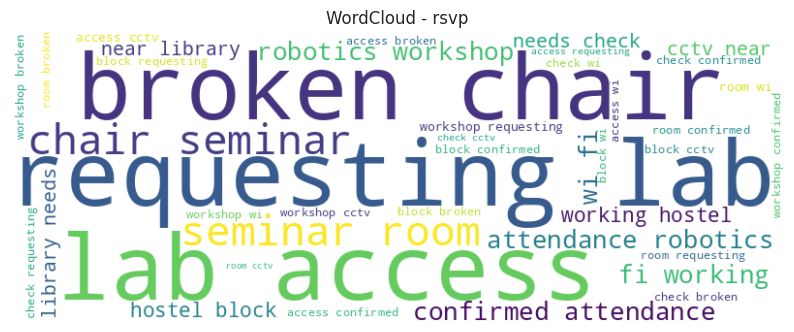

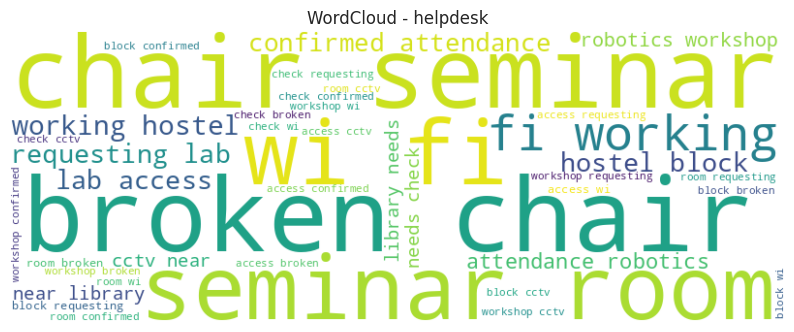

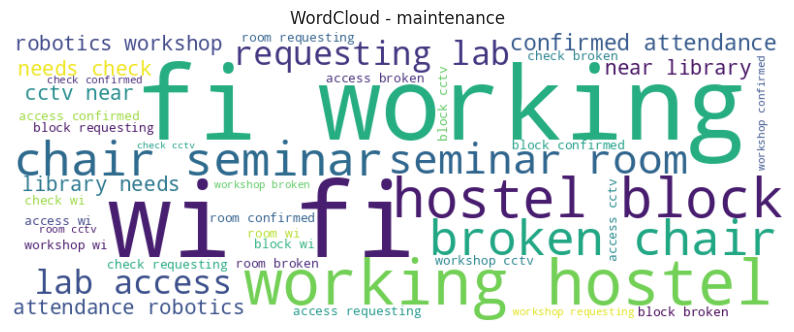

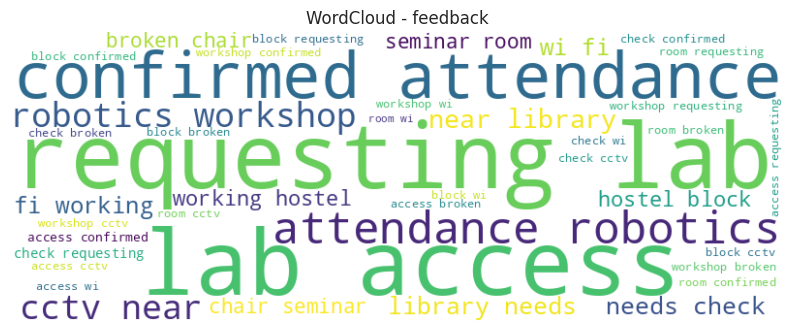

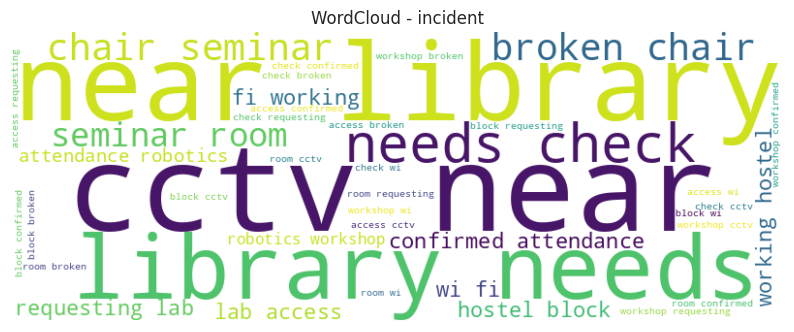

In [ ]:
all_text = " ".join(df['text_clean'].astype(str))
wc = WordCloud(width=1000, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation='bilinear'); plt.axis('off'); plt.title("WordCloud - All Text"); plt.show()

for cat in df['category'].unique():
    txt = " ".join(df.loc[df['category']==cat,'text_clean'])
    if len(txt.strip())==0:
        continue
    wc = WordCloud(width=800, height=300, background_color='white').generate(txt)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear'); plt.axis('off'); plt.title(f"WordCloud - {cat}"); plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = vectorizer.fit_transform(df['text'])


In [ ]:
n_features = X_tfidf.shape[1]
n_components = min(100, n_features - 1)

In [ ]:
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_reduced)

In [ ]:
print(df[['text', 'cluster']].head(20))


                                           text  cluster
0   Confirmed attendance for robotics workshop.        2
1            Wi-Fi not working in hostel block.        3
2                CCTV near library needs check.        4
3                 Broken chair in seminar room.        1
4            Wi-Fi not working in hostel block.        3
5                        Requesting lab access.        0
6            Wi-Fi not working in hostel block.        3
7   Confirmed attendance for robotics workshop.        2
8   Confirmed attendance for robotics workshop.        2
9   Confirmed attendance for robotics workshop.        2
10                       Requesting lab access.        0
11  Confirmed attendance for robotics workshop.        2
12                       Requesting lab access.        0
13                Broken chair in seminar room.        1
14                       Requesting lab access.        0
15                       Requesting lab access.        0
16           Wi-Fi not working 

In [ ]:
terms = vectorizer.get_feature_names_out()
for i in range(5):
    cluster_center = kmeans.cluster_centers_[i]
    top_idx = cluster_center.argsort()[-10:][::-1]
    top_terms = [terms[j] for j in top_idx]
    print(f"\nCluster {i} top terms: {top_terms}")


Cluster 0 top terms: ['access', 'broken', 'block', 'hostel', 'room', 'requesting', 'robotics', 'library', 'near', 'seminar']

Cluster 1 top terms: ['block', 'broken', 'chair', 'library', 'check', 'room', 'needs', 'seminar', 'confirmed', 'working']

Cluster 2 top terms: ['broken', 'attendance', 'cctv', 'hostel', 'chair', 'fi', 'requesting', 'robotics', 'needs', 'room']

Cluster 3 top terms: ['attendance', 'block', 'check', 'fi', 'confirmed', 'chair', 'robotics', 'wi', 'seminar', 'near']

Cluster 4 top terms: ['cctv', 'attendance', 'block', 'library', 'robotics', 'check', 'working', 'needs', 'requesting', 'near']


In [ ]:
print("Cluster sizes:")
print(df['cluster'].value_counts())

Cluster sizes:
cluster
0    1452
3    1411
1    1410
2    1375
4    1352
Name: count, dtype: int64


In [ ]:
df[['note_id','entity_id','category','text','text_clean','timestamp','cluster']].to_csv("/content/notes_clustered.csv", index=False)
print("Saved clustered results to /content/notes_clustered.csv")

Saved clustered results to /content/notes_clustered.csv


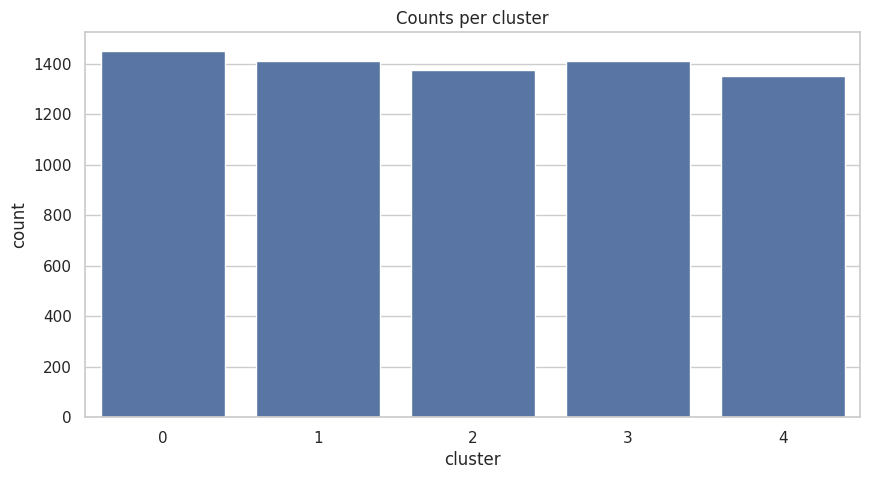

In [ ]:
plt.figure()
sns.countplot(x='cluster', data=df, order=sorted(df['cluster'].unique()))
plt.title("Counts per cluster")
plt.show()

In [ ]:
for c in sorted(df['cluster'].unique()):
    print(f"\n--- Sample texts from cluster {c} ---")
    display(df.loc[df['cluster']==c,['category','text']].head(6))



--- Sample texts from cluster 0 ---


,category,text
5,rsvp,Requesting lab access.
10,incident,Requesting lab access.
12,maintenance,Requesting lab access.
14,maintenance,Requesting lab access.
15,feedback,Requesting lab access.
20,helpdesk,Requesting lab access.



--- Sample texts from cluster 1 ---


,category,text
3,feedback,Broken chair in seminar room.
13,maintenance,Broken chair in seminar room.
29,rsvp,Broken chair in seminar room.
30,feedback,Broken chair in seminar room.
35,feedback,Broken chair in seminar room.
39,incident,Broken chair in seminar room.



--- Sample texts from cluster 2 ---


,category,text
0,rsvp,Confirmed attendance for robotics workshop.
7,feedback,Confirmed attendance for robotics workshop.
8,helpdesk,Confirmed attendance for robotics workshop.
9,maintenance,Confirmed attendance for robotics workshop.
11,incident,Confirmed attendance for robotics workshop.
17,maintenance,Confirmed attendance for robotics workshop.



--- Sample texts from cluster 3 ---


,category,text
1,helpdesk,Wi-Fi not working in hostel block.
4,incident,Wi-Fi not working in hostel block.
6,incident,Wi-Fi not working in hostel block.
16,incident,Wi-Fi not working in hostel block.
19,maintenance,Wi-Fi not working in hostel block.
22,helpdesk,Wi-Fi not working in hostel block.



--- Sample texts from cluster 4 ---


,category,text
2,maintenance,CCTV near library needs check.
18,rsvp,CCTV near library needs check.
38,incident,CCTV near library needs check.
40,rsvp,CCTV near library needs check.
60,rsvp,CCTV near library needs check.
81,incident,CCTV near library needs check.


# Topic Modeling (LDA) on the entire corpus

In [ ]:
count_vect = CountVectorizer(max_df=0.9, min_df=5, ngram_range=(1,2))
X_counts = count_vect.fit_transform(df['text_clean'])
print("Count matrix shape for LDA:", X_counts.shape)

n_topics = 6
lda = LDA(n_components=n_topics, random_state=42)
lda.fit(X_counts)


Count matrix shape for LDA: (7000, 37)


LatentDirichletAllocation(n_components=6, random_state=42)

In [ ]:
def print_lda_topics(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics[topic_idx] = top_features
        print("Topic %d:" % topic_idx, " ".join(top_features))
    return topics

lda_topics = print_lda_topics(lda, count_vect.get_feature_names_out(), 10)


Topic 0: requesting access lab requesting lab lab access seminar room seminar room chair broken chair
Topic 1: working wi wi fi fi working hostel block block working hostel hostel fi lab
Topic 2: cctv near near library near library needs library check cctv needs needs check access
Topic 3: lab access requesting lab requesting lab access chair broken chair seminar broken chair seminar room
Topic 4: room seminar chair seminar chair broken broken chair seminar room requesting access lab access
Topic 5: confirmed attendance workshop robotics attendance confirmed robotics workshop attendance robotics access requesting lab access


In [ ]:
lda_doc_topics = lda.transform(X_counts)
df['lda_topic'] = lda_doc_topics.argmax(axis=1)
print("Assigned LDA topic distribution:")
print(df['lda_topic'].value_counts())

Assigned LDA topic distribution:
lda_topic
3    1452
1    1411
4    1410
5    1375
2    1352
Name: count, dtype: int64


In [ ]:
df[['note_id','text','text_clean','lda_topic']].to_csv("/content/notes_lda_topics.csv", index=False)
print("Saved LDA topic assignments to /content/notes_lda_topics.csv")

Saved LDA topic assignments to /content/notes_lda_topics.csv


In [ ]:
#Anomaly Detection on daily counts

daily = df.groupby('date').size().rename('count').reset_index()
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date').set_index('date')


In [ ]:
# Simple statistical anomaly
mean = daily['count'].mean()
std = daily['count'].std()
threshold = mean + 3*std
daily['anomaly_stat'] = daily['count'] > threshold
print(f"Daily mean={mean:.2f} std={std:.2f} threshold={threshold:.2f}")
print("Dates flagged by simple threshold:", daily[daily['anomaly_stat']])

Daily mean=233.33 std=14.06 threshold=275.52
Dates flagged by simple threshold: Empty DataFrame
Columns: [count, anomaly_stat]
Index: []


In [ ]:
# IsolationForest on daily counts (scaled)
iso = IsolationForest(contamination=0.02, random_state=42)
daily_values = daily[['count']].values
daily_scaled = StandardScaler().fit_transform(daily_values)
iso_preds = iso.fit_predict(daily_scaled)  # -1 is anomaly
daily['anomaly_iso'] = (iso_preds == -1)
print("Dates flagged by IsolationForest:")
print(daily[daily['anomaly_iso']])

Dates flagged by IsolationForest:
            count  anomaly_stat  anomaly_iso
date                                        
2025-09-23    198         False         True


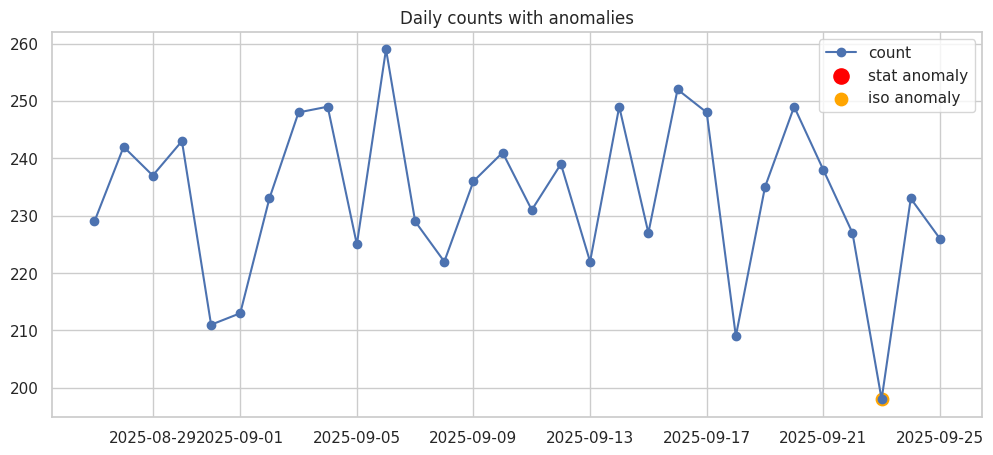

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily['count'], marker='o', label='count')
plt.scatter(daily.index[daily['anomaly_stat']], daily['count'][daily['anomaly_stat']], color='red', label='stat anomaly', s=120)
plt.scatter(daily.index[daily['anomaly_iso']], daily['count'][daily['anomaly_iso']], color='orange', label='iso anomaly', s=80)
plt.legend(); plt.title("Daily counts with anomalies"); plt.show()

In [ ]:
daily.reset_index().to_csv("/content/daily_anomaly_report.csv", index=False)
print("Saved daily anomaly report to /content/daily_anomaly_report.csv")

Saved daily anomaly report to /content/daily_anomaly_report.csv


In [ ]:

terms = vectorizer.get_feature_names_out()
cluster_keywords = {}

for i in range(kmeans.n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    top_idx = cluster_center.argsort()[-10:][::-1]
    top_terms = [terms[j] for j in top_idx]
    cluster_keywords[i] = top_terms


print("--- QUICK INSIGHTS ---")
print("Top categories:\n", df['category'].value_counts().head(10))

print("\nTop keywords per KMeans cluster:")
for k, v in cluster_keywords.items():
    print(f"Cluster {k}:", ", ".join(v[:8]))
print("\nTop words per LDA topic (printed above)")
print("\nAnomaly days by statistical rule:", daily[daily['anomaly_stat']].index.date.tolist())
print("Anomaly days by IsolationForest:", daily[daily['anomaly_iso']].index.date.tolist())



--- QUICK INSIGHTS ---
Top categories:
 category
maintenance    1441
feedback       1436
rsvp           1402
helpdesk       1365
incident       1356
Name: count, dtype: int64

Top keywords per KMeans cluster:
Cluster 0: access, broken, block, hostel, room, requesting, robotics, library
Cluster 1: block, broken, chair, library, check, room, needs, seminar
Cluster 2: broken, attendance, cctv, hostel, chair, fi, requesting, robotics
Cluster 3: attendance, block, check, fi, confirmed, chair, robotics, wi
Cluster 4: cctv, attendance, block, library, robotics, check, working, needs

Top words per LDA topic (printed above)

Anomaly days by statistical rule: []
Anomaly days by IsolationForest: [datetime.date(2025, 9, 23)]


In [ ]:
out_cols = ['note_id','entity_id','category','text','text_clean','timestamp','cluster','lda_topic']
df[out_cols].to_csv("/content/notes_eda_full.csv", index=False)
print("Saved full EDA result to /content/notes_eda_full.csv")

Saved full EDA result to /content/notes_eda_full.csv
